In [1]:
import pandas as pd
import numpy as np
import openpyxl
import os
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

e:\Installation\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
e:\Installation\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
def read_excel(file):
    df = pd.read_excel(file)
    return df

dfs = []

# loop through all files in the folder and read them and append them to the list

for file in glob.glob('../../Data/Processed data/*.xlsx'):
    print(file)
    df = read_excel(file)
    dfs.append(df)

../../Data/Processed data\250 shojja.xlsx
../../Data/Processed data\31 shojja.xlsx
../../Data/Processed data\ad-din.xlsx
../../Data/Processed data\aichi.xlsx
../../Data/Processed data\Al manar.xlsx
../../Data/Processed data\Anowar khan.xlsx
../../Data/Processed data\azgol ali.xlsx
../../Data/Processed data\Delta medical.xlsx
../../Data/Processed data\Dhaka central.xlsx
../../Data/Processed data\dmd central.xlsx
../../Data/Processed data\h&h.xlsx
../../Data/Processed data\hfrc.xlsx
../../Data/Processed data\ibn sina.xlsx
../../Data/Processed data\islami bank.xlsx
../../Data/Processed data\lstm_dmc.xlsx
../../Data/Processed data\Medical college for women.xlsx
../../Data/Processed data\Metropoliton medical.xlsx
../../Data/Processed data\police hospital.xlsx
../../Data/Processed data\popular medical.xlsx
../../Data/Processed data\Sajeda hospital.xlsx
../../Data/Processed data\shomorita.xlsx
../../Data/Processed data\Square.xlsx
../../Data/Processed data\ssmc.xlsx
../../Data/Processed data\

In [3]:
index_of_hospital_for_prediction = 14

In [4]:
def preprocess(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].values.astype(float)
    #sort by date
    df = df.sort_values(by='Date')
    # for rows where df['Affected'] is null or non-numeric, replace with 0
    df['Affected'] = pd.to_numeric(df['Affected'], errors='coerce').fillna(0).astype(float)
    df.reset_index(drop=True, inplace=True)
    return df

In [5]:
i=1

for df in dfs:
    print(str(i))
    df = preprocess(df)
    print("done ")
    i+=1

1
done 
2
done 
3
done 
4
done 
5
done 
6
done 
7
done 
8
done 
9
done 
10
done 
11
done 
12
done 
13
done 
14
done 
15
done 
16
done 
17
done 
18
done 
19
done 
20
done 
21
done 
22
done 
23
done 
24
done 
25
done 
26
done 


In [6]:
dfs[index_of_hospital_for_prediction].head()

,Date,Affected
0,1.567296e+18,92.0
1,1.567382e+18,82.0
2,1.567469e+18,64.0
3,1.567555e+18,47.0
4,1.567642e+18,63.0


In [7]:
# make all the dfs equal size: equal to the size of the hospital with index for prediction
# get the hospital with highest df
# get the index of the hospital with highest df


# for each 'Date' value in the hospital with index for prediction, if other hospitals do not have that 'Date' value, add that 'Date' value to the other hospitals with 'Affected' value as 0
for i in range(len(dfs)):
    if i != index_of_hospital_for_prediction:
        for date in dfs[index_of_hospital_for_prediction]['Date']:
            if date not in dfs[i]['Date'].values:
                dfs[i] = pd.concat([dfs[i], pd.DataFrame({'Date': [date], 'Affected': [0]})], ignore_index=True)
        
# If any df has any date value that is not in the hospital with index for prediction, remove that row from the df
for i in range(len(dfs)):
    if i != index_of_hospital_for_prediction:
        for date in dfs[i]['Date']:
            if date not in dfs[index_of_hospital_for_prediction]['Date'].values:
                dfs[i] = dfs[i][dfs[i]['Date'] != date]


In [8]:
# print size of all dfs
for df in dfs:
    print(df.shape)

(698, 2)
(698, 2)
(698, 2)
(698, 2)
(698, 2)
(698, 2)
(698, 2)
(698, 2)
(698, 2)
(698, 2)
(698, 2)
(698, 2)
(698, 2)
(698, 2)
(698, 2)
(698, 2)
(698, 2)
(698, 2)
(698, 2)
(698, 2)
(698, 2)
(698, 2)
(698, 2)
(698, 2)
(698, 2)
(698, 2)


In [9]:
# concat all the dfs to one df keeping only the 'Affected' column and keeping our index for prediction as the first column
df = dfs[index_of_hospital_for_prediction]
for i in range(len(dfs)):
    if i != index_of_hospital_for_prediction:
        df = pd.concat([df, dfs[i]['Affected']], axis=1)

df.head()

,Date,Affected,Affected,Affected,Affected,Affected,Affected,Affected,Affected,Affected,...,Affected,Affected,Affected,Affected,Affected,Affected,Affected,Affected,Affected,Affected
0,1.567296e+18,92.0,-,-,0,6.0,13.0,-,-,-,...,1.0,-,-,7.0,-,1,-,-,-,2
1,1.567382e+18,82.0,NaN,NaN,0,13.0,8.0,-,-,1,...,0.0,-,-,4.0,-,1,4,-,1,1
2,1.567469e+18,64.0,NaN,NaN,0,13.0,18.0,-,2,-,...,2.0,-,-,7.0,-,-,-,-,1,1
3,1.567555e+18,47.0,NaN,NaN,0,14.0,14.0,NaN,NaN,NaN,...,2.0,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1.567642e+18,63.0,-,-,0,17.0,15.0,NaN,NaN,NaN,...,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#drop the 'Date' column
df = df.drop(columns=['Date'])
df.head()

,Affected,Affected,Affected,Affected,Affected,Affected,Affected,Affected,Affected,Affected,...,Affected,Affected,Affected,Affected,Affected,Affected,Affected,Affected,Affected,Affected
0,92.0,-,-,0,6.0,13.0,-,-,-,0.0,...,1.0,-,-,7.0,-,1,-,-,-,2
1,82.0,NaN,NaN,0,13.0,8.0,-,-,1,0.0,...,0.0,-,-,4.0,-,1,4,-,1,1
2,64.0,NaN,NaN,0,13.0,18.0,-,2,-,1.0,...,2.0,-,-,7.0,-,-,-,-,1,1
3,47.0,NaN,NaN,0,14.0,14.0,NaN,NaN,NaN,0.0,...,2.0,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN
4,63.0,-,-,0,17.0,15.0,NaN,NaN,NaN,2.0,...,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# replace any non numeric values with 0
df = df.apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)
df.head()

,Affected,Affected,Affected,Affected,Affected,Affected,Affected,Affected,Affected,Affected,...,Affected,Affected,Affected,Affected,Affected,Affected,Affected,Affected,Affected,Affected
0,92.0,0.0,0.0,0.0,6.0,13.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,7.0,0.0,1.0,0.0,0.0,0.0,2.0
1,82.0,0.0,0.0,0.0,13.0,8.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,4.0,0.0,1.0,4.0,0.0,1.0,1.0
2,64.0,0.0,0.0,0.0,13.0,18.0,0.0,2.0,0.0,1.0,...,2.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,1.0,1.0
3,47.0,0.0,0.0,0.0,14.0,14.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
4,63.0,0.0,0.0,0.0,17.0,15.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# rename columns to 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
df.columns = range(len(df.columns))
df.head(20)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,92.0,0.0,0.0,0.0,6.0,13.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,7.0,0.0,1.0,0.0,0.0,0.0,2.0
1,82.0,0.0,0.0,0.0,13.0,8.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,4.0,0.0,1.0,4.0,0.0,1.0,1.0
2,64.0,0.0,0.0,0.0,13.0,18.0,0.0,2.0,0.0,1.0,...,2.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,1.0,1.0
3,47.0,0.0,0.0,0.0,14.0,14.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
4,63.0,0.0,0.0,0.0,17.0,15.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
6,33.0,0.0,0.0,2.0,8.0,19.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,9.0,0.0,0.0,0.0,1.0,1.0,3.0
7,52.0,0.0,0.0,2.0,8.0,18.0,0.0,0.0,0.0,2.0,...,3.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
8,81.0,0.0,0.0,2.0,5.0,18.0,0.0,0.0,0.0,4.0,...,3.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
9,49.0,0.0,0.0,0.0,7.0,13.0,0.0,0.0,0.0,4.0,...,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
coordinates = [(23.78023378522258, 90.36734693327269),
               (23.717878894611427, 90.37687614386095),
               (23.74854258987857, 90.4054805619277),
               (23.881790066203926, 90.40410896582604),
               (23.756052674223117, 90.36321845418024),
               (23.74530536688184, 90.38222402534431),
               (23.70789594683928, 90.42361642349367),
               (23.788602125062823, 90.35348610815265),
               (23.74361497588872, 90.38411443909085),
               (23.743909512744548, 90.38430874415275),
               (23.751892721210428, 90.38546900815183),
               (23.74692774941598, 90.40312845418005),
               (23.752132125860218, 90.41353537340008),
               (23.73972361480249, 90.4206285118513),
               (23.726327283426574, 90.39766652719375),
               (23.858439631417777, 90.40093773883972),
               (23.858439631417777, 90.40089482349694),
               (23.736396173493542, 90.41672412478748),
               (23.739433993904264, 90.38224623884184),
               (23.703267796399004, 90.3887789409448),
               (23.753565317444227, 90.3852717198413),
               (23.752951798763714, 90.38150615233585),
               (23.710654780247634, 90.40201004780278),
               (23.804802336161362, 90.41579431185583),
               (23.77636504355202, 90.39571531185526),
               (23.87475779737836, 90.39663462350299),
               ]

# find distance between two coordinates
def distance(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return d

# find distances between index for prediction and all other hospitals except its own and store them in a list
distances = []
for i in range(len(coordinates)):
    if i != index_of_hospital_for_prediction:
        distances.append(distance(coordinates[index_of_hospital_for_prediction][0], coordinates[index_of_hospital_for_prediction][1], coordinates[i][0], coordinates[i][1]))

distances



[6.741786507601015,
 2.315576491957656,
 2.595120831268563,
 17.29909352386097,
 4.818628548641938,
 2.6313543087042004,
 3.3435628527924064,
 8.256377387716334,
 2.3660454226280807,
 2.3813816464892588,
 3.1020378597474707,
 2.3571697800287708,
 3.292756803610191,
 2.7716472235698077,
 14.69399272474776,
 14.69389447099225,
 2.239826120149679,
 2.1419201945303965,
 2.7190569264240207,
 3.280988801674936,
 3.386786964460765,
 1.797925988393371,
 8.918901576810232,
 5.567487959839648,
 16.505054002375246]

Text(0.5, 0, 'Hospital')

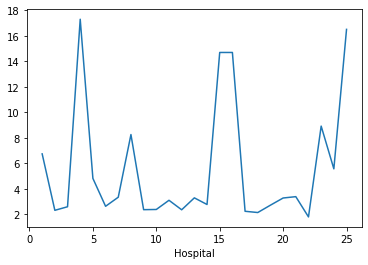

In [14]:
# plot distances for y values 1,2,3
plt.plot(range(1, len(distances)+1), distances)
plt.xlabel('Hospital')

In [15]:
adjacent_matrix = []

for i in range(len(distances)):
    if distances[i] < 2.5:
        adjacent_matrix.append(1)
    else:
        adjacent_matrix.append(0)

# # Compute the softmax of each row to normalize the adjacency matrix
# adjacent_matrix_softmax = F.softmax(adjacent_matrix, dim=1)

In [16]:
len(adjacent_matrix)

25

In [17]:
# update first column's data in such way that it is addition of current data and weighted sum of other columns. weight is the distance between the hospital and index for prediction hospital
# less the distance, more the weight

for i in range(len(df)):
    for j in range(1, len(df.columns)):
        df.iloc[i, 0] += df.iloc[i, j] * adjacent_matrix[j-1]

df.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,92.0,0.0,0.0,0.0,6.0,13.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,7.0,0.0,1.0,0.0,0.0,0.0,2.0
1,86.0,0.0,0.0,0.0,13.0,8.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,4.0,0.0,1.0,4.0,0.0,1.0,1.0
2,66.0,0.0,0.0,0.0,13.0,18.0,0.0,2.0,0.0,1.0,...,2.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,1.0,1.0
3,47.0,0.0,0.0,0.0,14.0,14.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
4,65.0,0.0,0.0,0.0,17.0,15.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# GAT layer

class GATLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.fc = nn.Linear(in_dim, out_dim)
        self.a = nn.Parameter(torch.zeros(size=(2*out_dim, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        self.leakyrelu = nn.LeakyReLU(0.2)

    def forward(self, h):
        N = h.size()[0]
        a_input = torch.cat([h.repeat(1, N).view(N*N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2*self.out_dim)
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adjacent_matrix, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, 0.6, training=self.training)
        h_prime = torch.matmul(attention, h)
        h_prime = F.elu(self.fc(h_prime))
        return h_prime

In [19]:
# GAT model

class GAT(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(GAT, self).__init__()
        self.layer1 = GATLayer(in_dim, hidden_dim)
        self.layer2 = GATLayer(hidden_dim, out_dim)

    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        return h
    
# convert df to tensor
df_tensor = torch.tensor(df.values, dtype=torch.float32)

# create model
model = GAT(df_tensor.shape[1], 8, 1)

# create optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# create loss function
criterion = nn.MSELoss()

# train model
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(df_tensor)
    loss = criterion(output, df_tensor[:, 0].view(-1, 1))
    loss.backward()
    optimizer.step()
    print('Epoch: {}/{}, Loss: {}'.format(epoch+1, epochs, loss.item()))

# get predictions
predictions = model(df_tensor).detach().numpy()
predictions


TypeError: where() received an invalid combination of arguments - got (list, Tensor, Tensor), but expected one of:
 * (Tensor condition)
 * (Tensor condition, Tensor input, Tensor other, *, Tensor out)
 * (Tensor condition, Number self, Tensor other)
      didn't match because some of the arguments have invalid types: (!list!, !Tensor!, Tensor)
 * (Tensor condition, Tensor input, Number other)
      didn't match because some of the arguments have invalid types: (!list!, Tensor, !Tensor!)
 * (Tensor condition, Number self, Number other)
      didn't match because some of the arguments have invalid types: (!list!, !Tensor!, !Tensor!)


In [ ]:
# create a new dataframe with only the first column

data = pd.DataFrame(df.iloc[:, 0])
data.head()

,0
0,NaN
1,86.0
2,66.0
3,47.0
4,65.0


In [ ]:
# defining hyperparameters
num_epochs = 500
learning_rate = 0.001
batch_size = 32
input_size = 14
prediction_window = 3
window_size = input_size + prediction_window
hidden_size = 64
num_layers = 1


print("num_epochs: ", num_epochs, " learning_rate: ", learning_rate, " batch_size: ", batch_size, " window_size: ", window_size, " input_size: ", input_size, " num_layers: ", num_layers)

num_epochs:  500  learning_rate:  0.001  batch_size:  32  window_size:  17  input_size:  14  num_layers:  1


In [ ]:
def create_time_series_samples(df, window_size):
    samples = []

    for i in range(len(df) - window_size + 1):
        sample = df.iloc[i:i + window_size]
        samples.append(sample)

    return samples

samples = create_time_series_samples(data, window_size)

In [ ]:
samples[1]

,0
1,86.0
2,66.0
3,47.0
4,65.0
5,61.0
6,33.0
7,54.0
8,85.0
9,53.0
10,53.0


In [ ]:
# make a dataframe where first row is the first column of the first sample, second row is the first column of the second sample and so on

data = pd.DataFrame([sample.iloc[:, 0].values for sample in samples])
data.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,NaN,86.0,66.0,47.0,65.0,61.0,33.0,54.0,85.0,53.0,53.0,45.0,35.0,41.0,39.0,46.0,50.0
1,86.0,66.0,47.0,65.0,61.0,33.0,54.0,85.0,53.0,53.0,45.0,35.0,41.0,39.0,46.0,50.0,36.0
2,66.0,47.0,65.0,61.0,33.0,54.0,85.0,53.0,53.0,45.0,35.0,41.0,39.0,46.0,50.0,36.0,43.0
3,47.0,65.0,61.0,33.0,54.0,85.0,53.0,53.0,45.0,35.0,41.0,39.0,46.0,50.0,36.0,43.0,41.0
4,65.0,61.0,33.0,54.0,85.0,53.0,53.0,45.0,35.0,41.0,39.0,46.0,50.0,36.0,43.0,41.0,24.0


In [ ]:
def train_test_split(df, split_ratio, shuffle):
    if shuffle:
        df = df.sample(frac=1)

    split_index = int(len(df) * split_ratio)
    train = df[:split_index]
    test = df[split_index:]

    return train, test

train_df , test_df = train_test_split(data, 0.8, False)

In [ ]:
def split_X_y(df):
    #last prediction_window columns are y
    y = df.iloc[:, -prediction_window:]
    #first window_size - prediction_window columns are X
    X = df.iloc[:, :input_size]
    return X, y

X_train, y_train = split_X_y(train_df)
X_test, y_test = split_X_y(test_df)

In [ ]:
print("X_train.shape: ", X_train.shape, " y_train.shape: ", y_train.shape, " X_test.shape: ", X_test.shape, " y_test.shape: ", y_test.shape)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, prediction_window)  

    def forward(self, x):
        h_t, _ = self.lstm(x)
        output = self.fc(h_t[:, -1, :]) 
        return output
    
model = LSTMModel(input_size, hidden_size, num_layers)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    train_losses[epoch] = loss.item()

model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor.unsqueeze(1))
    test_loss = criterion(test_outputs.squeeze(), y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

predictions = test_outputs.numpy()

X_train.shape:  (563, 14)  y_train.shape:  (563, 3)  X_test.shape:  (141, 14)  y_test.shape:  (141, 3)
Epoch [1/500], Loss: nan
Epoch [2/500], Loss: nan
Epoch [3/500], Loss: nan
Epoch [4/500], Loss: nan
Epoch [5/500], Loss: nan
Epoch [6/500], Loss: nan
Epoch [7/500], Loss: nan
Epoch [8/500], Loss: nan
Epoch [9/500], Loss: nan
Epoch [10/500], Loss: nan
Epoch [11/500], Loss: nan
Epoch [12/500], Loss: nan
Epoch [13/500], Loss: nan
Epoch [14/500], Loss: nan
Epoch [15/500], Loss: nan
Epoch [16/500], Loss: nan
Epoch [17/500], Loss: nan
Epoch [18/500], Loss: nan
Epoch [19/500], Loss: nan
Epoch [20/500], Loss: nan
Epoch [21/500], Loss: nan
Epoch [22/500], Loss: nan
Epoch [23/500], Loss: nan
Epoch [24/500], Loss: nan
Epoch [25/500], Loss: nan
Epoch [26/500], Loss: nan
Epoch [27/500], Loss: nan
Epoch [28/500], Loss: nan
Epoch [29/500], Loss: nan
Epoch [30/500], Loss: nan
Epoch [31/500], Loss: nan
Epoch [32/500], Loss: nan
Epoch [33/500], Loss: nan
Epoch [34/500], Loss: nan
Epoch [35/500], Loss: 

In [ ]:
#get the first column of the test set
y_test_1 = y_test[:, 0]
# y_test_2 = y_test[:, 1]
# y_test_3 = y_test[:, 2]

# #get the first column of the predictions
predictions_1 = predictions[:, 0]
# predictions_2 = predictions[:, 1]
# predictions_3 = predictions[:, 2]

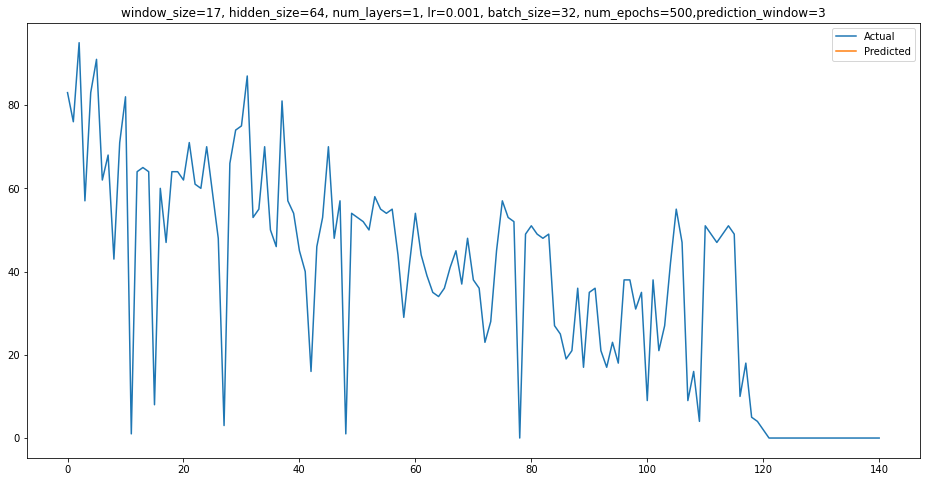

In [ ]:
plt.figure(figsize=(16,8))
plt.title(f'window_size={window_size}, hidden_size={hidden_size}, num_layers={num_layers}, lr={learning_rate}, batch_size={batch_size}, num_epochs={num_epochs},prediction_window={prediction_window}')
plt.plot(y_test_1, label='Actual')
plt.plot(predictions_1, label='Predicted')
plt.legend()
plt.show()

In [ ]:
# MAE, MSE, RMSE losses
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test_1, predictions_1)
mse = mean_squared_error(y_test_1, predictions_1)
rmse = np.sqrt(mse)
print("MAE: ", mae, " MSE: ", mse, " RMSE: ", rmse)

ValueError: Input contains NaN.

In [ ]:
# print errors in 2 decimal places
print("MAE: {:.2f}".format(mae), " MSE: {:.2f}".format(mse), " RMSE: {:.2f}".format(rmse))

MAE: 13.30  MSE: 308.71  RMSE: 17.57
